# Data preprocessing

## emotion label + path to file

In [49]:
#!/home/judehey/miniconda3/envs/myenv/bin/python

import pandas as pd
import numpy as np
import os

pathToData="../data/ravdess/"
imgsPath="../imgs/ravdess/"
modelsPath="../models/ravdess/"

def load_data(path):
    emotion, file_path = [], []
    
    # iterate over song, speech folders, every actor subfolder and audio files in
    for folder in os.listdir(path):
        for subfolder in os.listdir(path + folder):
            for file in os.listdir(path + folder + "/" + subfolder):
                emotion.append(file.split("-")[2])
                file_path.append(path + folder + "/" + subfolder + "/" + file)
                
    # prepare dataframe
    audio_df = pd.DataFrame(emotion)
    audio_df = audio_df.replace({"01": "neutral", "02": "calm", "03": "happy", "04": "sad", "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"})
    
    # concatenate file paths to emotion data frame
    audio_df = pd.concat([pd.DataFrame(file_path), audio_df], axis=1)
    audio_df.columns = ['path', 'emotion']
    
    return audio_df

df = load_data(pathToData)
df

,path,emotion
0,../data/ravdess/Audio_Speech_Actors_01-24/Acto...,happy
1,../data/ravdess/Audio_Speech_Actors_01-24/Acto...,calm
2,../data/ravdess/Audio_Speech_Actors_01-24/Acto...,happy
3,../data/ravdess/Audio_Speech_Actors_01-24/Acto...,surprised
4,../data/ravdess/Audio_Speech_Actors_01-24/Acto...,calm
...,...,...
2447,../data/ravdess/Audio_Song_Actors_01-24/Actor_...,fearful
2448,../data/ravdess/Audio_Song_Actors_01-24/Actor_...,angry
2449,../data/ravdess/Audio_Song_Actors_01-24/Actor_...,angry
2450,../data/ravdess/Audio_Song_Actors_01-24/Actor_...,sad


# Feature extraction

- [mfcc extraction info](https://www.researchgate.net/profile/Teddy-Gunawan/publication/353296706_Speech_Emotion_Recognition_Using_Feature_Fusion_of_TEO_and_MFCC_on_Multilingual_Databases/links/613ef96f4e1df2710631ca0a/Speech-Emotion-Recognition-Using-Feature-Fusion-of-TEO-and-MFCC-on-Multilingual-Databases.pdf)
- [librosa docs](https://librosa.org/doc/latest/index.html)

In [50]:
import librosa

# log-mel spectrogram into mfcc

logMelSpecVal = []

def parse_audio_file(pathToFile, _duration, sampleRate, _offset):
    # load file
    wavf, sample_rate = librosa.load(pathToFile, res_type="kaiser_fast", duration=_duration, sr=sampleRate, offset=_offset)
    
    # get mfcc features (coefficients = 13, filters = 32)
    mfcc = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=wavf, sr=sample_rate, n_mfcc = 13), axis=0)
    
    return mfcc

mfccVal = []

for fpath in df['path']:
    mfcc = parse_audio_file(fpath, 4, 44100, 0.5)
    mfccVal.append(mfcc)
    
# merge emotions with features
df = pd.concat([df, pd.DataFrame(mfccVal)], axis=1)
    
# drop unnecessary column
df.drop(columns='path', inplace=True)

# fill na's
df = df.fillna(0)
df.head()

,emotion,0,1,2,3,4,5,6,7,8,...,335,336,337,338,339,340,341,342,343,344
0,happy,-48.413395,-48.075798,-47.574280,-47.451622,-48.135826,-48.706688,-48.955540,-48.112358,-46.947311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,calm,-66.689575,-66.082527,-66.983719,-64.977615,-62.615215,-62.309586,-62.451180,-60.948093,-59.981323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,happy,-48.638100,-48.638100,-48.638100,-48.638100,-48.638100,-48.638100,-48.638100,-48.076477,-47.975407,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,surprised,-58.190613,-58.190613,-58.190613,-58.190613,-58.190613,-58.190613,-58.190613,-58.190613,-58.190613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,calm,-67.372910,-67.372910,-67.372910,-67.372910,-67.372910,-67.372910,-67.376183,-65.081711,-61.741520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plots

## class distribution

['happy' 'calm' 'surprised' 'angry' 'fearful' 'disgust' 'sad' 'neutral']


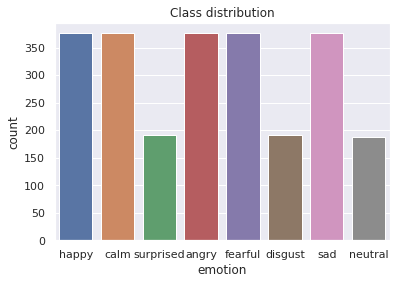

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# class imbalance plot
def class_imbalance_plot():
    print(df['emotion'].unique())
    sns.set_theme(style='darkgrid')
    sns.countplot(x = 'emotion', data = df)
    plt.title('Class distribution')
    plt.savefig(imgsPath + 'class_imbalance.png')
    plt.show()
    return

class_imbalance_plot()

## waveform

## log-mel spectrogram

# Data split

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def data_split(df):
    # divide data into labels and features
    X = df.iloc[:, :].drop(columns=['emotion'])
    y = df['emotion']
    
    # stratified train, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_split(df)

print(X_train.head())
print(y_train.head())

            0          1          2          3          4          5    \
759  -65.591377 -65.540787 -65.591377 -65.591377 -65.505386 -64.501968   
343  -57.263977 -57.263977 -56.639229 -56.887520 -57.263977 -57.263977   
139  -41.861794 -41.680698 -41.918819 -42.079815 -41.785030 -41.377090   
120  -51.646004 -51.646004 -51.646004 -51.646004 -51.646004 -51.646004   
1048 -68.325424 -68.325424 -68.325424 -68.325424 -68.325424 -68.325424   

            6          7          8          9    ...        335        336  \
759  -61.365719 -62.756821 -65.424454 -65.591377  ...   0.000000   0.000000   
343  -57.263977 -57.263977 -57.263977 -56.851582  ...   0.000000   0.000000   
139  -40.835270 -41.420681 -40.971836 -41.009720  ... -34.532997 -30.199177   
120  -51.646004 -51.646004 -51.646004 -51.646004  ...   0.000000   0.000000   
1048 -68.325424 -68.325424 -68.325424 -68.325424  ...   0.000000   0.000000   

      337  338  339  340  341  342  343  344  
759   0.0  0.0  0.0  0.0  0.0  0.

# Data preprocessing

In [53]:
from keras.utils import to_categorical

def data_preprocessing(X_train, X_test, y_train, y_test):

    # normalization (z-score, values between -1 and 1)
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std

    # turn data into arrays for keras
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(y_train.shape)
    print(y_test.shape)

    # label one hot encoding
    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_test = to_categorical(lb.fit_transform(y_test))

    print(y_test[0:3])

    print(lb.classes_)

    # data reshaping
    X_train = X_train[:,:,np.newaxis]
    X_test = X_test[:,:,np.newaxis]

    print(X_train.shape)
    
    return X_train, X_test, y_train, y_test, lb

X_train, X_test, y_train, y_test, lb = data_preprocessing(X_train, X_test, y_train, y_test)

(1961,)
(491,)
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]
['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
(1961, 345, 1)


# Model architecture

- [model architecture info](https://www.researchgate.net/profile/Gregor-Hofer-3/publication/335829168_Analysis_of_Deep_Learning_Architectures_for_Cross-Corpus_Speech_Emotion_Recognition/links/5e2f0a2f4585152d156d9f4f/Analysis-of-Deep-Learning-Architectures-for-Cross-Corpus-Speech-Emotion-Recognition.pdf)

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.utils import plot_model

def get_model():
    #BUILD 1D CNN LAYERS
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='sigmoid'))
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    
    return model

model = get_model()
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 336, 64)           704       
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 327, 128)          82048     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 40, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 31, 128)           163968    
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 3, 128)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 128)          

# Model training and export


Epoch 00001: val_accuracy improved from -inf to 0.27699, saving model to ../models/ravdess/model_1_CNN
INFO:tensorflow:Assets written to: ../models/ravdess/model_1_CNN/assets

Epoch 00002: val_accuracy improved from 0.27699 to 0.28921, saving model to ../models/ravdess/model_1_CNN
INFO:tensorflow:Assets written to: ../models/ravdess/model_1_CNN/assets

Epoch 00003: val_accuracy improved from 0.28921 to 0.31568, saving model to ../models/ravdess/model_1_CNN
INFO:tensorflow:Assets written to: ../models/ravdess/model_1_CNN/assets

Epoch 00004: val_accuracy improved from 0.31568 to 0.34827, saving model to ../models/ravdess/model_1_CNN
INFO:tensorflow:Assets written to: ../models/ravdess/model_1_CNN/assets

Epoch 00005: val_accuracy improved from 0.34827 to 0.36049, saving model to ../models/ravdess/model_1_CNN
INFO:tensorflow:Assets written to: ../models/ravdess/model_1_CNN/assets

Epoch 00006: val_accuracy improved from 0.36049 to 0.36456, saving model to ../models/ravdess/model_1_CNN
I

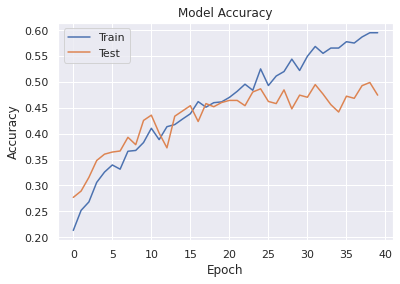

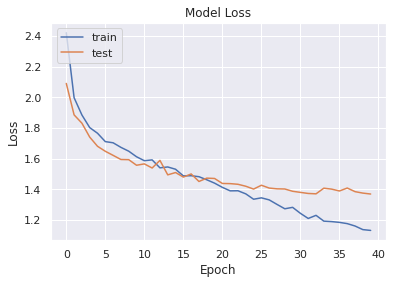

In [55]:
from keras.callbacks import ModelCheckpoint

# use checkpoints to save best model
checkpoint = ModelCheckpoint(modelsPath + 'model_1_CNN', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# fit model
model_history = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test), callbacks=[checkpoint], verbose=0)

# plot model accuracy and loss over epochs
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(imgsPath + 'Initial_Model_Accuracy.png')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(imgsPath + 'Initial_Model_loss.png')
plt.show()

# Results

## accuracy and loss

In [56]:
# loss and accuracy percentage on test set
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

16/16 [==============================] - 0s 3ms/step - loss: 1.3697 - accuracy: 0.4745
Loss of the model is -  1.3697431087493896
16/16 [==============================] - 0s 3ms/step - loss: 1.3697 - accuracy: 0.4745
Accuracy of the model is -  47.45417535305023 %


In [57]:
# predictions
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# actual labels
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# combine both
finaldf = actual.join(predictions)
finaldf[1:10]

,Actual Values,Predicted Values
1,sad,sad
2,calm,disgust
3,neutral,calm
4,angry,angry
5,calm,calm
6,sad,sad
7,angry,angry
8,calm,calm
9,disgust,disgust


## confusion matrix

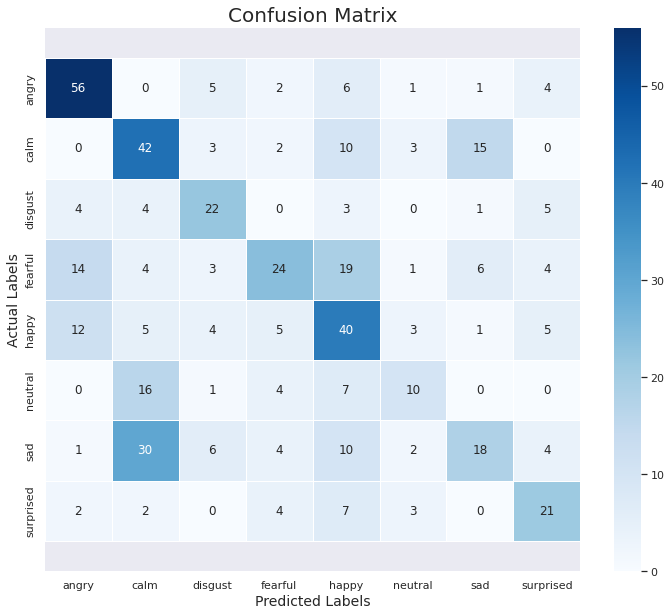

In [58]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix, actual vs predicted
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig(imgsPath + 'Initial_Model_Confusion_Matrix.png')
plt.show()

In [59]:
print(classification_report(actual, predictions, target_names = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']))

              precision    recall  f1-score   support

       angry       0.63      0.75      0.68        75
        calm       0.41      0.56      0.47        75
     disgust       0.50      0.56      0.53        39
     fearful       0.53      0.32      0.40        75
       happy       0.39      0.53      0.45        75
     neutral       0.43      0.26      0.33        38
         sad       0.43      0.24      0.31        75
   surprised       0.49      0.54      0.51        39

    accuracy                           0.47       491
   macro avg       0.48      0.47      0.46       491
weighted avg       0.48      0.47      0.46       491

